Processing Batches: 100%|████████████████████| 75/75 [07:06<00:00,  5.69s/batch]


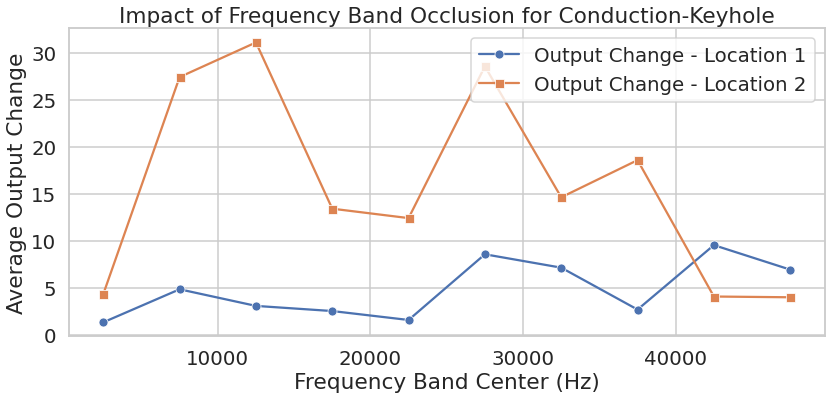

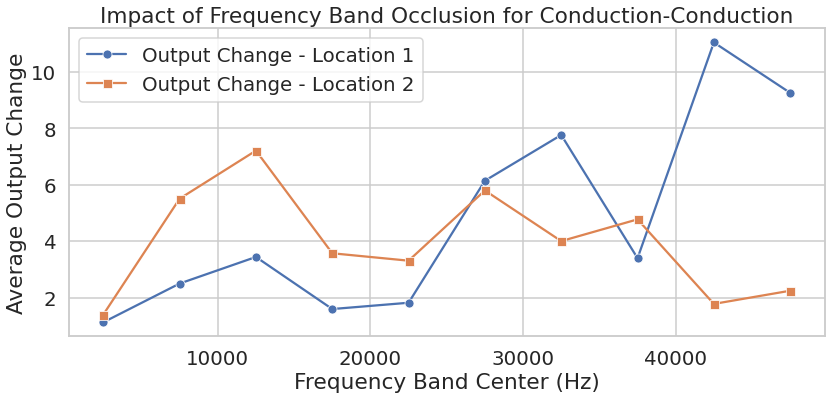

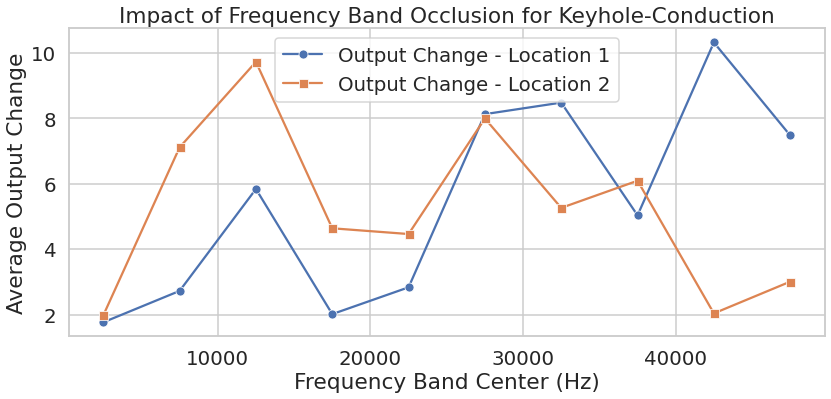

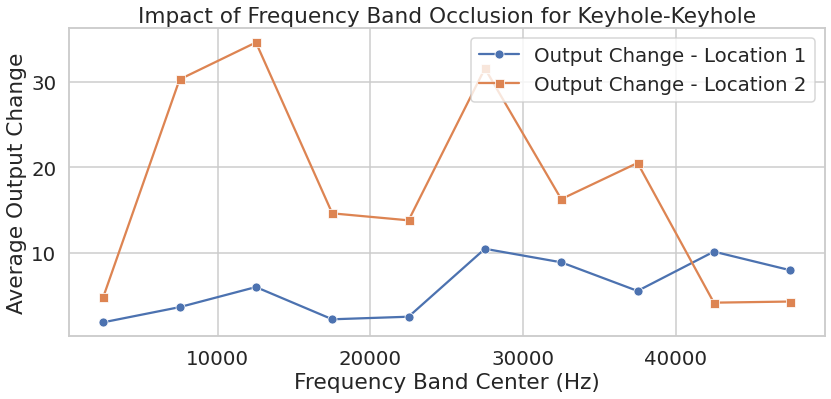

T-statistic: nan, P-value: nan
Frequency bands with maximum average output change for each regime combination:
                          regime_combination  frequency_band_center  \
regime_combination                                                    
Conduction-Conduction  Conduction-Conduction                42500.0   
Conduction-Keyhole        Conduction-Keyhole                42500.0   
Keyhole-Conduction        Keyhole-Conduction                42500.0   
Keyhole-Keyhole              Keyhole-Keyhole                27500.0   

                       output_change1  output_change2  
regime_combination                                     
Conduction-Conduction       11.039413        1.779177  
Conduction-Keyhole           9.554292        4.094106  
Keyhole-Conduction          10.320460        2.036426  
Keyhole-Keyhole             10.476115       31.590342  


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.signal import butter, sosfilt
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import pandas as pd
import random
from tqdm import tqdm  # For progress bars

# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Define the SignalClassifier model (DUAL DISCO architecture)
class SignalClassifier(nn.Module):
    def __init__(self, input_channels, filter_size, win_len):
        super(SignalClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=2, kernel_size=filter_size, padding='same')
        self.bn1 = nn.BatchNorm1d(2)
        self.prelu1 = nn.PReLU()

        # Branch 1 layers
        self.branch1_layers = nn.ModuleList()
        self.branch1_bns = nn.ModuleList()
        for i in range(2):
            self.branch1_layers.append(nn.Conv1d(in_channels=2 if i == 0 else 8, out_channels=8, kernel_size=filter_size, padding='same'))
            self.branch1_bns.append(nn.BatchNorm1d(8))
        self.branch1_prelus = nn.ModuleList([nn.PReLU() for _ in range(2)])
        self.out_branch1 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=filter_size, padding='same')

        self.fc1_branch1 = nn.Linear(8*win_len, 128)
        self.fc2_branch1 = nn.Linear(128, 1)

        # Branch 2 layers
        self.branch2_layers = nn.ModuleList()
        self.branch2_bns = nn.ModuleList()
        for i in range(2):
            self.branch2_layers.append(nn.Conv1d(in_channels=2 if i == 0 else 8, out_channels=8, kernel_size=filter_size, padding='same'))
            self.branch2_bns.append(nn.BatchNorm1d(8))
        self.branch2_prelus = nn.ModuleList([nn.PReLU() for _ in range(2)])
        self.out_branch2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=filter_size, padding='same')

        self.fc1_branch2 = nn.Linear(8*win_len, 128)
        self.fc2_branch2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.prelu1(self.bn1(self.conv1(x)))

        # Branch 1 forward pass
        x_branch1 = x
        for layer, bn, prelu in zip(self.branch1_layers, self.branch1_bns, self.branch1_prelus):
            x_branch1 = prelu(bn(layer(x_branch1)))
        x_branch1_f = self.out_branch1(x_branch1)
        x_branch1_flat = x_branch1_f.view(x_branch1_f.size(0), -1)
        x_branch1_fc = F.relu(self.fc1_branch1(x_branch1_flat))
        out1 = self.fc2_branch1(x_branch1_fc)

        # Branch 2 forward pass
        x_branch2 = x
        for layer, bn, prelu in zip(self.branch2_layers, self.branch2_bns, self.branch2_prelus):
            x_branch2 = prelu(bn(layer(x_branch2)))
        x_branch2_f = self.out_branch2(x_branch2)
        x_branch2_flat = x_branch2_f.view(x_branch2_f.size(0), -1)
        x_branch2_fc = F.relu(self.fc1_branch2(x_branch2_flat))
        out2 = self.fc2_branch2(x_branch2_fc)

        return out1, out2, x_branch1_f, x_branch2_f

# Define the custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, modes, names):
        self.data = data
        self.modes = modes
        self.names = names

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        mode = self.modes[idx]
        name = self.names[idx]
        return sample, mode, name

# Load the test data and filter only the rear sensor
test_database_sim = torch.load('./Data/test_classification_short_TEST')
test_names_sim = test_database_sim['file_names']
test_modes_sim = test_database_sim['mode_descriptions']

def mode_to_int(mode):
    return 0 if 'Conduction' in mode else 1

# Convert mode descriptions to integer labels
test_modes_int_sim = [(mode_to_int(mode0), mode_to_int(mode1)) for mode0, mode1 in test_modes_sim]
test_data_sim = test_database_sim['sim_tensor']
test_data_sim_a = test_data_sim.narrow(1, 1, 1)  # Only rear sensor data

# Create DataLoader
test_dataset_sim = CustomDataset(test_data_sim_a, test_modes_int_sim, test_names_sim)
test_loader_sim = DataLoader(test_dataset_sim, batch_size=64, shuffle=True)

# Load the pre-trained model
model_sim_path = './best_model_only_rear.pth'
model_sim_data = torch.load(model_sim_path, map_location=torch.device('cpu'))
win_len = test_data_sim_a.shape[2]
best_filter_size_sim = model_sim_data['conv1.weight'].shape[-1]

device = torch.device("cpu")
model_sim = SignalClassifier(input_channels=test_data_sim_a.shape[1],
                             filter_size=best_filter_size_sim, win_len=win_len).to(device)
model_sim.load_state_dict(model_sim_data)
model_sim.eval()

# Function to create a band-stop filter
def band_stop_filter(lowcut, highcut, fs, order=4):
    """
    Creates a Butterworth band-stop filter.
    """
    sos = butter(order, [lowcut, highcut], btype='bandstop', fs=fs, output='sos')
    return sos

# Function to apply the band-stop filter to the signal
def apply_filter(sos, signal):
    """
    Applies the band-stop filter to the signal.
    """
    filtered_signal = sosfilt(sos, signal, axis=-1)
    return filtered_signal

# Define frequency bands to occlude
frequency_bands = [(1, 5000), (5000, 10000), (10000, 15000), (15000, 20000),
                   (20000, 25000), (25000, 30000), (30000, 35000), (35000, 40000),
                   (40000, 45000), (45000, 50000)]
sampling_rate = 200000  # Sampling rate of the data

# Initialize a list to store results
data_records = []

# Begin analysis with the model in evaluation mode
model_sim.eval()
with torch.no_grad():
    # Iterate over batches in the test DataLoader
    for data, (target1, target2), _ in tqdm(test_loader_sim, desc="Processing Batches", unit="batch"):
        data = data.to(device)
        target1, target2 = target1.to(device).float(), target2.to(device).float()

        # Get original outputs without any filtering
        output1_orig, output2_orig, _, _ = model_sim(data)

        # Iterate over each frequency band to occlude
        for lowcut, highcut in frequency_bands:
            sos = band_stop_filter(lowcut, highcut, sampling_rate)

            # Apply filter to data
            data_filtered = data.clone()
            for i in range(data.size(0)):
                # Assuming data is of shape [batch_size, channels, time]
                signal = data_filtered[i, 0].cpu().numpy()
                filtered_signal = apply_filter(sos, signal)
                data_filtered[i, 0] = torch.from_numpy(filtered_signal)
            data_filtered = data_filtered.to(device)

            # Get outputs with filtered data
            output1_filtered, output2_filtered, _, _ = model_sim(data_filtered)

            # Compute change in outputs
            output_change1 = torch.abs(output1_filtered - output1_orig).cpu().numpy()
            output_change2 = torch.abs(output2_filtered - output2_orig).cpu().numpy()

            # Collect data for analysis, including regime combinations
            for oc1, oc2, t1, t2 in zip(output_change1, output_change2, target1.cpu().numpy(), target2.cpu().numpy()):
                # Determine the regime combination
                if t1 == 0 and t2 == 0:
                    regime_combination = 'Conduction-Conduction'
                elif t1 == 0 and t2 == 1:
                    regime_combination = 'Conduction-Keyhole'
                elif t1 == 1 and t2 == 0:
                    regime_combination = 'Keyhole-Conduction'
                elif t1 == 1 and t2 == 1:
                    regime_combination = 'Keyhole-Keyhole'

                data_records.append({
                    'frequency_band_center': (lowcut + highcut) / 2,
                    'output_change1': oc1[0],
                    'output_change2': oc2[0],
                    'target1': int(t1),
                    'target2': int(t2),
                    'regime_combination': regime_combination
                })

# Create a DataFrame for analysis
df = pd.DataFrame(data_records)

# Analyze the impact of frequency band occlusion
grouped = df.groupby(['regime_combination', 'frequency_band_center']).mean().reset_index()

# Visualization of the results
sns.set(style='whitegrid', context='talk', font_scale=1.2)

for regime_combination in df['regime_combination'].unique():
    subset = grouped[grouped['regime_combination'] == regime_combination]
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=subset, x='frequency_band_center', y='output_change1', marker='o', label='Output Change - Location 1')
    sns.lineplot(data=subset, x='frequency_band_center', y='output_change2', marker='s', label='Output Change - Location 2')
    plt.title(f'Impact of Frequency Band Occlusion for {regime_combination}')
    plt.xlabel('Frequency Band Center (Hz)')
    plt.ylabel('Average Output Change')
    plt.legend()
    plt.tight_layout()
    plt.show()




In [13]:
mid_freqs = [(low+high)/2 for low, high in frequency_bands]
mid_freqs

[2500.5,
 7500.0,
 12500.0,
 17500.0,
 22500.0,
 27500.0,
 32500.0,
 37500.0,
 42500.0,
 47500.0]

Created/Modified files during execution:
Conduction_Keyhole.pdf
Conduction_Conduction.pdf
Keyhole_Conduction.pdf
Keyhole_Keyhole.pdf


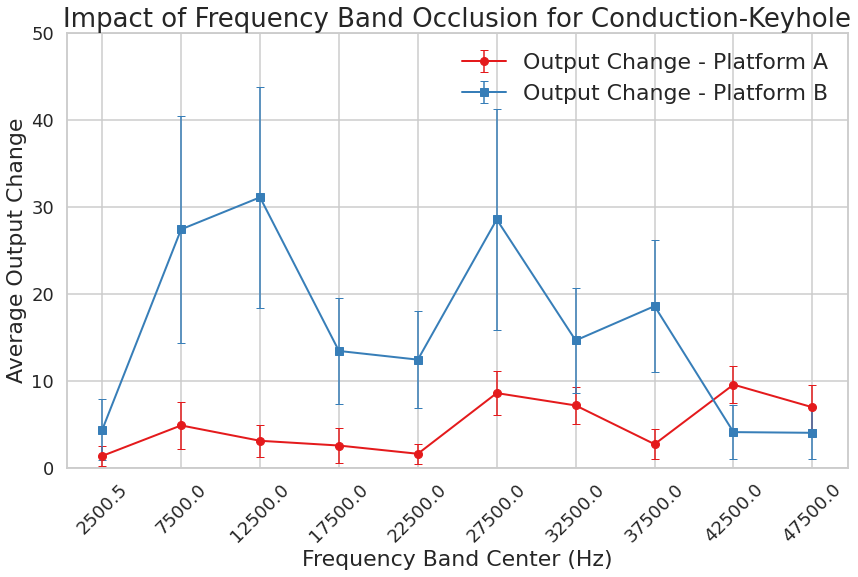

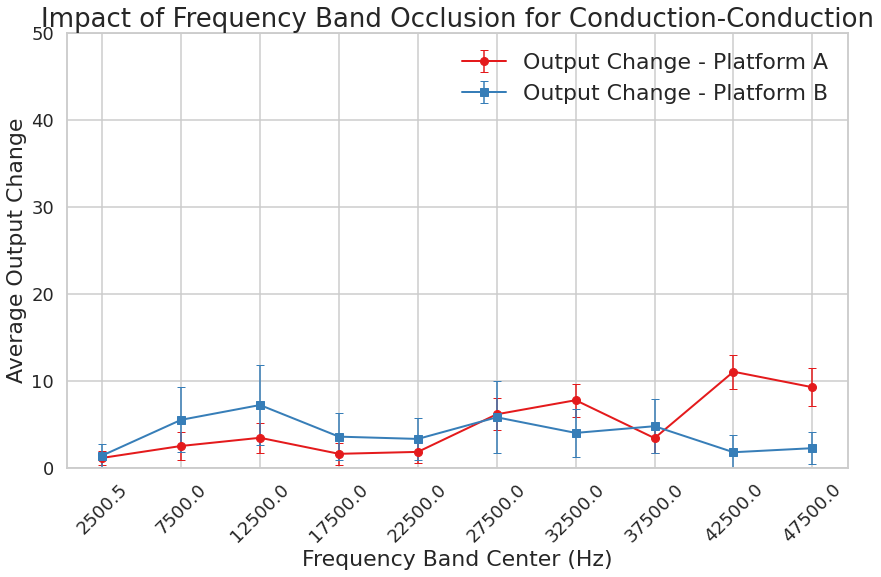

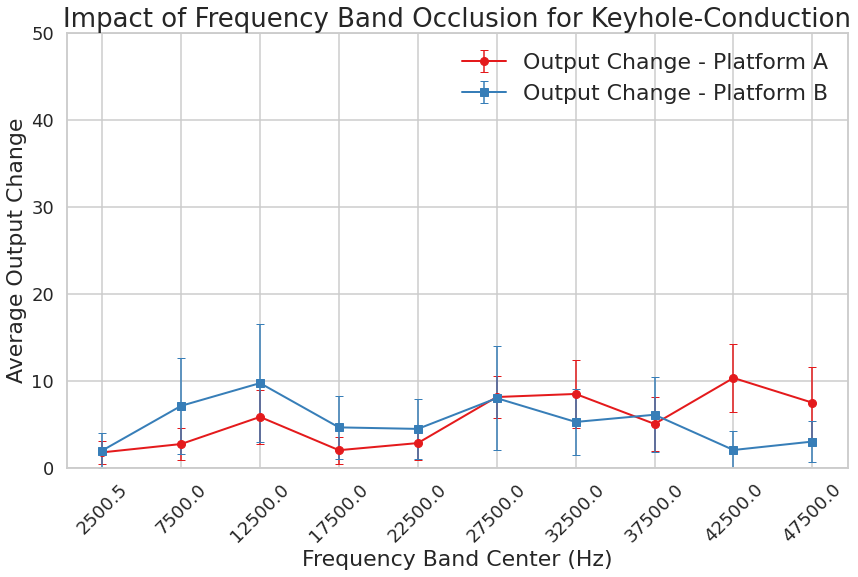

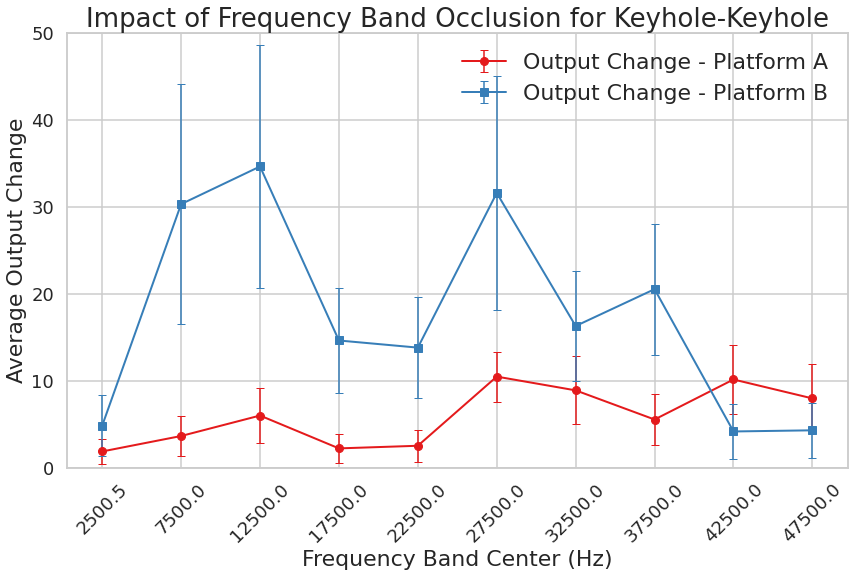

In [51]:
import os 
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the Figures directory exists
os.makedirs('./Figures', exist_ok=True)

# Analyze the impact of frequency band occlusion
# Compute both mean and standard deviation
grouped = df.groupby(['regime_combination', 'frequency_band_center']).agg({
    'output_change1': ['mean', 'std'],
    'output_change2': ['mean', 'std']
}).reset_index()

# Flatten the MultiIndex columns
grouped.columns = [
    'regime_combination',
    'frequency_band_center',
    'output_change1_mean',
    'output_change1_std',
    'output_change2_mean',
    'output_change2_std'
]

# Visualization of the results with enhanced aesthetics
sns.set(style='whitegrid', context='talk', font_scale=2.)

# Define a color palette
palette = sns.color_palette("Set1", n_colors=2)

for regime_combination in df['regime_combination'].unique():
    subset = grouped[grouped['regime_combination'] == regime_combination]

    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plot for Platform A
    ax1.errorbar(
        x=subset['frequency_band_center'],
        y=subset['output_change1_mean'],
        yerr=subset['output_change1_std'],
        fmt='-o',
        capsize=4,
        markersize=8,
        linewidth=2,
        color=palette[0],
        ecolor=palette[0],
        elinewidth=1.5,
        label='Output Change - Platform A'
    )

    # Plot for Platform B on the same y-axis
    ax1.errorbar(
        x=subset['frequency_band_center'],
        y=subset['output_change2_mean'],
        yerr=subset['output_change2_std'],
        fmt='-s',
        capsize=4,
        markersize=8,
        linewidth=2,
        color=palette[1],
        ecolor=palette[1],
        elinewidth=1.5,
        label='Output Change - Platform B'
    )

    # Setting labels and limits
    ax1.set_xlabel('Frequency Band Center (Hz)', fontsize=22)
    ax1.set_ylabel('Average Output Change', fontsize=22)
    ax1.set_ylim(0, 50)  # Adjusted to cover the full range of both platforms
    ax1.set_xticks(subset['frequency_band_center'])
    ax1.set_xticklabels(subset['frequency_band_center'], rotation=45, fontsize=22)
    ax1.tick_params(axis='y', labelsize=18)
    ax1.tick_params(axis='x', labelsize=18)

    # Add title and grid
    plt.title(f'Impact of Frequency Band Occlusion for {regime_combination}', fontsize=26)
    ax1.grid(True)

    # Combine legends
    ax1.legend(fontsize=22)

    # Save the figure with an appropriate name
    filename = f'./Figures/{regime_combination.replace("-", "_")}.pdf'
    plt.savefig(filename, format='pdf', dpi=300, bbox_inches='tight')
    # plt.close()

# Print the names of the files created
print("Created/Modified files during execution:")
for regime_combination in df['regime_combination'].unique():
    print(f'{regime_combination.replace("-", "_")}.pdf')


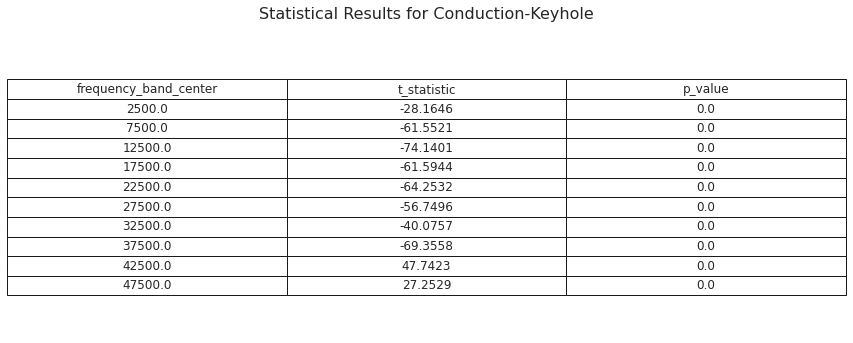

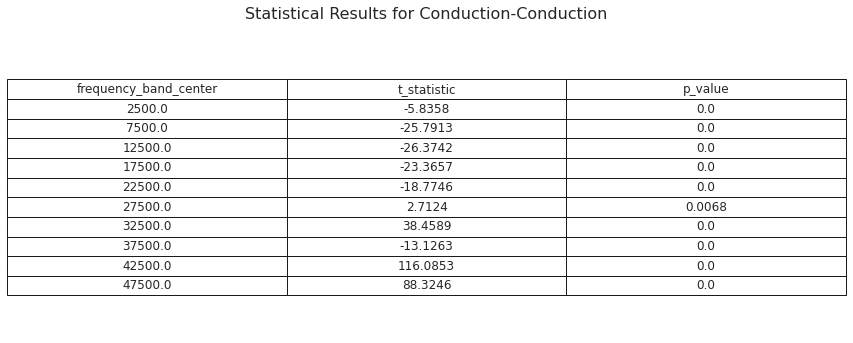

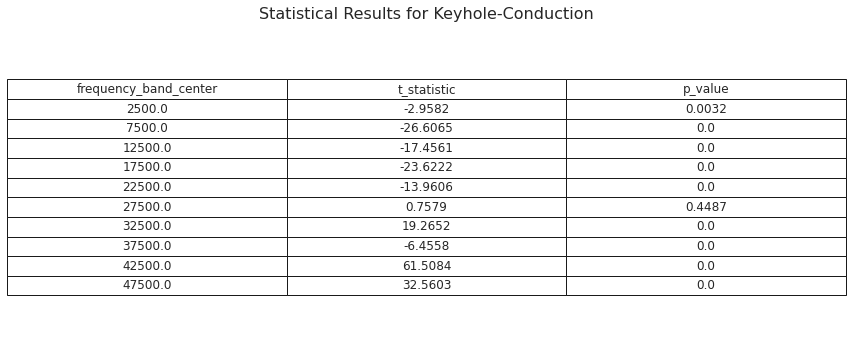

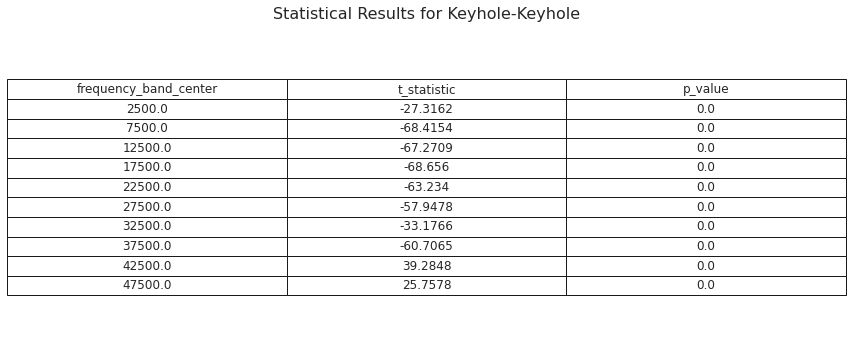

All statistical results have been plotted.


In [55]:

# Perform statistical analysis
statistical_results = []

for regime_combination in df['regime_combination'].unique():
    for freq_band in df['frequency_band_center'].unique():
        subset = df[(df['regime_combination'] == regime_combination) & 
                    (df['frequency_band_center'] == freq_band)]
        
        # Perform paired t-test
        t_statistic, p_value = stats.ttest_rel(subset['output_change1'], subset['output_change2'])
        
        statistical_results.append({
            'regime_combination': regime_combination,
            'frequency_band_center': freq_band,
            't_statistic': t_statistic,
            'p_value': p_value
        })

# Convert results to DataFrame
stats_df = pd.DataFrame(statistical_results)

# Set up the plot style
plt.style.use('seaborn')
sns.set(font_scale=1.2)

# Create and plot tables for each configuration
for regime_combination in stats_df['regime_combination'].unique():
    subset = stats_df[stats_df['regime_combination'] == regime_combination]
    
    # Create a formatted table
    table = subset[['frequency_band_center', 't_statistic', 'p_value']].copy()
    table['frequency_band_center'] = table['frequency_band_center'].astype(int)
    table['t_statistic'] = table['t_statistic'].round(4)
    table['p_value'] = table['p_value'].round(4)
    table = table.sort_values('frequency_band_center')
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, len(table) * 0.5))
    
    # Hide axes
    ax.axis('off')
    
    # Plot the table
    table_plot = ax.table(cellText=table.values,
                          colLabels=table.columns,
                          cellLoc='center',
                          loc='center')
    
    # Set font size and style
    table_plot.auto_set_font_size(False)
    table_plot.set_fontsize(12)
    table_plot.scale(1.2, 1.5)
    
    # Color code p-values
    for (row, col), cell in table_plot.get_celld().items():
        if col == 3 and row != 0:  # p-value column, excluding header
            if table.iloc[row-1, col-1] < 0.05:
                cell.set_facecolor('#90EE90')  # Light green for significant p-values
            else:
                cell.set_facecolor('#FFA07A')  # Light salmon for non-significant p-values
    
    # Add a title
    plt.title(f"Statistical Results for {regime_combination}", fontsize=16, pad=20)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

